In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)
!nvidia-smi
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

HOME: /content
Tue Feb 20 12:38:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)
import os

import cv2
import supervision as sv

image_bgr = cv2.imread("yagoda.jpg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

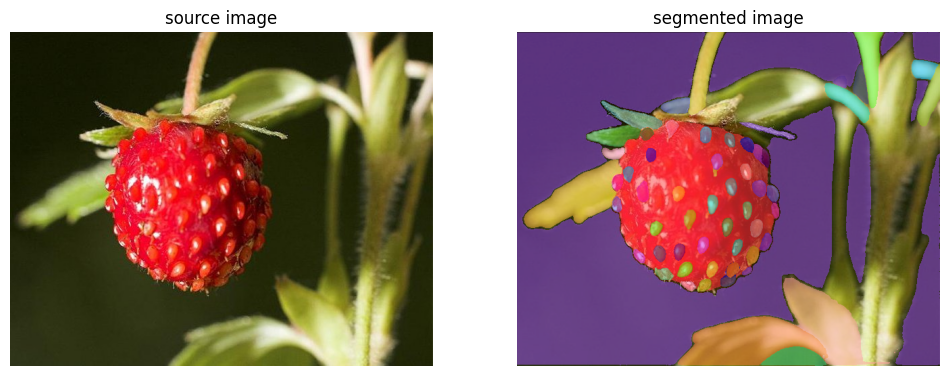

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

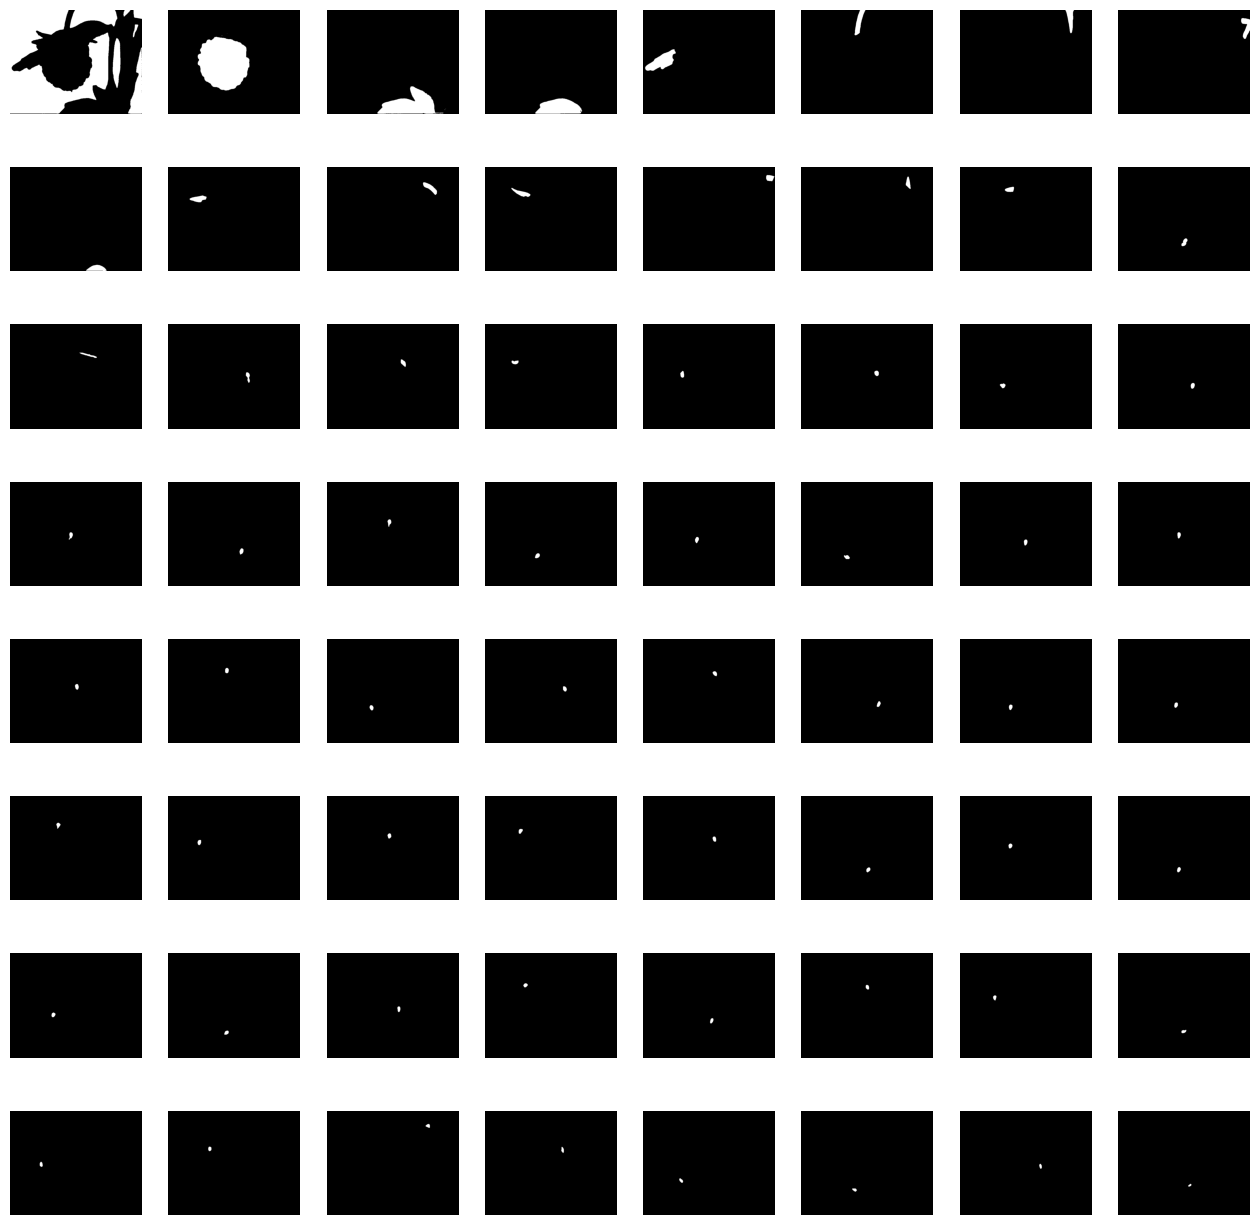

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

import math

sv.plot_images_grid(
    images=masks,
    grid_size=(8, math.ceil(len(masks) / 8)),
    size=(16, 16)
)

In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:
import os

IMAGE_NAME = "yagoda.jpg"
IMAGE_PATH = os.path.join(HOME, IMAGE_NAME)

In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 111, 'y': 72, 'width': 319, 'height': 333, 'label': ''}]

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 1, 'y': 1, 'width': 700, 'height': 467, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [ ]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

<ipython-input-171-725e7c36f98b>:1: DeprecationWarning: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.RED` instead.
  box_annotator = sv.BoxAnnotator(color=sv.Color.red())
<ipython-input-171-725e7c36f98b>:2: DeprecationWarning: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.RED` instead.
  mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)


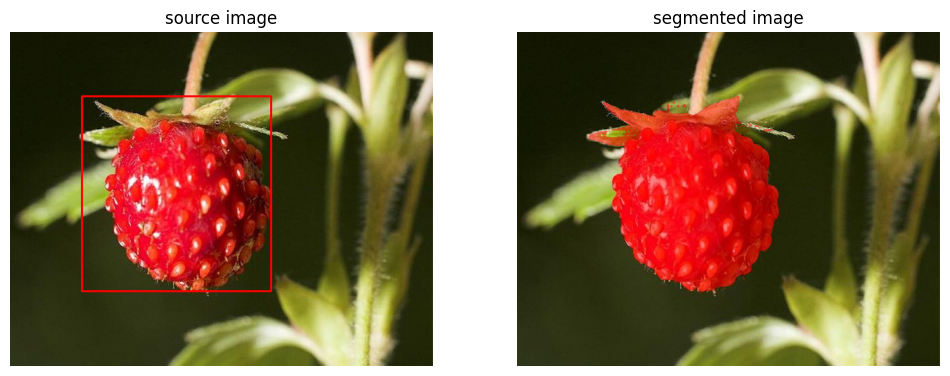

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

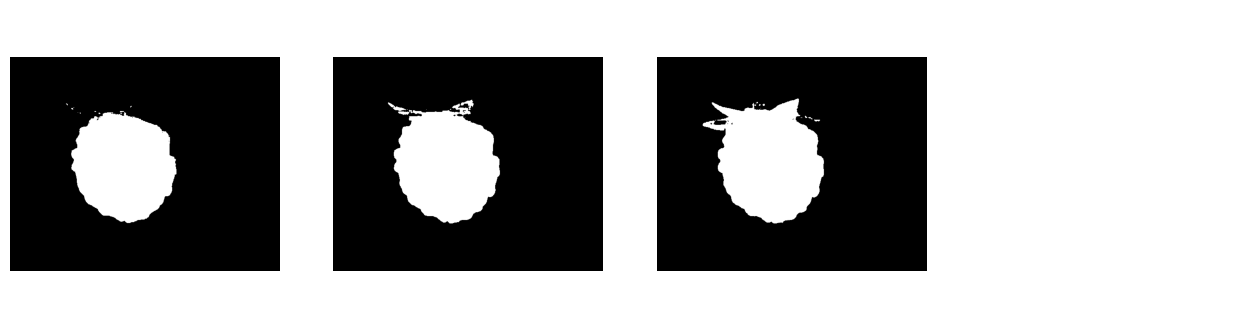

In [ ]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

In [ ]:
import cv2
import numpy as np

mask = masks[0]

white_background = np.ones_like(source_image) * 255

for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i, j] > 0:
            white_background[i, j, :3] = source_image[i, j, :3]

cv2.imwrite('segmented_image.png', white_background)

True

In [ ]:
mask = masks[0].astype(np.uint8)  # Убедитесь, что маска в правильном формате

# Находим контуры в маске
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Выбираем наибольший контур по площади, если есть несколько контуров
max_contour = max(contours, key=cv2.contourArea)

# max_contour теперь содержит массив точек контура наиболее крупного объекта
print(max_contour)

[[[265 127]]

 [[265 130]]

 [[264 131]]

 [[264 133]]

 [[265 134]]

 [[263 136]]

 [[260 136]]

 [[258 134]]

 [[256 134]]

 [[254 132]]

 [[252 132]]

 [[251 133]]

 [[250 133]]

 [[249 132]]

 [[247 132]]

 [[246 133]]

 [[245 133]]

 [[243 131]]

 [[242 131]]

 [[241 132]]

 [[240 132]]

 [[238 130]]

 [[238 128]]

 [[225 128]]

 [[224 129]]

 [[219 129]]

 [[218 130]]

 [[217 130]]

 [[216 131]]

 [[215 131]]

 [[215 135]]

 [[213 137]]

 [[212 137]]

 [[211 136]]

 [[210 137]]

 [[209 137]]

 [[208 138]]

 [[207 138]]

 [[205 140]]

 [[205 144]]

 [[203 146]]

 [[201 146]]

 [[200 145]]

 [[202 143]]

 [[202 142]]

 [[203 141]]

 [[203 140]]

 [[201 138]]

 [[200 138]]

 [[199 137]]

 [[196 137]]

 [[195 138]]

 [[195 140]]

 [[193 142]]

 [[188 142]]

 [[187 143]]

 [[187 144]]

 [[185 146]]

 [[184 146]]

 [[184 147]]

 [[183 148]]

 [[183 151]]

 [[182 152]]

 [[182 154]]

 [[181 155]]

 [[181 156]]

 [[180 157]]

 [[180 158]]

 [[178 160]]

 [[177 160]]

 [[176 161]]

 [[170

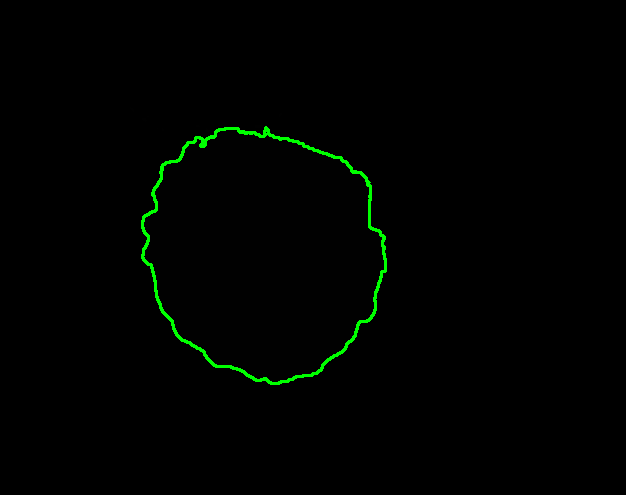

In [ ]:
from google.colab.patches import cv2_imshow
from google.colab.patches import cv2_imshow

# После того как вы нашли контуры и, возможно, нарисовали их на копии изображения:
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    output_image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)  # Преобразуем маску обратно в BGR для визуализации
    cv2.drawContours(output_image, [largest_contour], -1, (0, 255, 0), 2)  # Рисуем контур зеленым цветом

    # Используйте cv2_imshow вместо cv2.imshow для отображения изображения
    cv2_imshow(output_image)
else:
    print("No contours found")